#0. Data Access

In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {}.".format(device.type))

Using cuda.


In [5]:
from pathlib import Path

LOCAL_RUNTIME = False

if not LOCAL_RUNTIME:
    from google.colab import drive
    data_dir = Path("/content/Data/")

    if not (data_dir.is_dir() and any(data_dir.iterdir())):
        drive.mount('/content/drive/')

        if not data_dir.is_dir():
            !mkdir /content/Data/

        intra_dir = data_dir / "Intra"
        cross_dir = data_dir / "Cross"

        if not (
            intra_dir.is_dir()
            and any(subdir.is_file() for subdir in intra_dir.iterdir())
            and cross_dir.is_dir()
            and any(subdir.is_file() for subdir in cross_dir.iterdir())
        ):
            !unzip '/content/drive/MyDrive/Data/DL/Intra.zip' -d '/content/Data/' > /dev/null
            !unzip '/content/drive/MyDrive/Data/DL/Cross.zip' -d '/content/Data/' > /dev/null

        drive.flush_and_unmount()
else:
    raise ValueError("This code is intended to run in Google Colab. Please switch to a Colab environment.")

assert data_dir.is_dir()

intra_dir = data_dir / "Intra"
cross_dir = data_dir / "Cross"
cross_train_glob = list((cross_dir / "train").glob("*.h5"))
cross_test1_glob = list((cross_dir / "test1").glob("*.h5"))
cross_test2_glob = list((cross_dir / "test2").glob("*.h5"))
cross_test3_glob = list((cross_dir / "test3").glob("*.h5"))
print(len(cross_train_glob), len(cross_test1_glob), len(cross_test2_glob))


Mounted at /content/drive/
64 16 16


#1. Data Preprocessing



Data Preparation and Labeling

In [6]:
import h5py
import numpy as np

def load_labels(path: Path) -> np.ndarray:
    *task, subject_identifier, chunk = path.stem.split("_")
    if "rest" in task:
        y = 0
    elif 'math' in task:
        y = 1
    elif 'working' in task:
        y = 2
    elif 'motor' in task:
        y = 3
    else:
        assert False, 'unknown task'
    return np.array([y, int(subject_identifier), int(chunk)])

def load_h5(path: Path) -> np.ndarray:
    with h5py.File(path) as f:
        keys = f.keys()
        assert len(keys) == 1, f"Only one key per file, right? {cross_train_files[0]}"
        matrix = f.get(next(iter(keys)))[()]
    return matrix


In [7]:
cross_train_X = np.stack(list(map(load_h5, cross_train_glob)))
cross_train_labels = np.stack(list(map(load_labels, cross_train_glob)))[:, 0]

#Load first test dataset
cross_test1_X = np.stack([load_h5(file) for file in cross_test1_glob])
cross_test1_labels = np.stack([load_labels(file) for file in cross_test1_glob])[:, 0]

#Load second test dataset
cross_test2_X = np.stack([load_h5(file) for file in cross_test2_glob])
cross_test2_labels = np.stack([load_labels(file) for file in cross_test2_glob])[:, 0]

#Load third test dataset
cross_test3_X = np.stack([load_h5(file) for file in cross_test3_glob])
cross_test3_labels = np.stack([load_labels(file) for file in cross_test3_glob])[:, 0]

print(cross_test1_X.shape, cross_test1_labels.shape)

(16, 248, 35624) (16,)


Preprocessing: downsampling and normalization

In [8]:
import torch

def downsample(data, old_freq, new_freq):
    # Calculate the downsampling factor
    downsample_factor = int(np.round(old_freq / new_freq))
    # Ensure that timesteps are divisible by the downsampling factor
    data = data[:,:,:data.shape[2]//downsample_factor*downsample_factor]
    # Reshape
    reshaped_data = data.reshape(data.shape[0], data.shape[1], -1, downsample_factor)
    # Take the mean along the last axis
    downsampled_data = reshaped_data.mean(axis=-1)
    return downsampled_data

def z_score_normalize(data):
    # Convert to PyTorch tensor
    data_tensor = torch.tensor(data, dtype=torch.float32)
    # Calculate mean and std along the timesteps
    mean = torch.mean(data_tensor, dim=2, keepdim=True)
    std = torch.std(data_tensor, dim=2, keepdim=True)
    # Perform z-score norm
    normalized_data = (data_tensor - mean) / std
    return normalized_data

cross_train_X_norm = z_score_normalize(downsample(cross_train_X, 2034, 30))
cross_test1_X_norm = z_score_normalize(downsample(cross_test1_X, 2034, 30))
cross_test2_X_norm = z_score_normalize(downsample(cross_test2_X, 2034, 30))
cross_test3_X_norm = z_score_normalize(downsample(cross_test3_X, 2034, 30))

print(cross_train_X_norm.shape, cross_test1_X_norm.shape)

del cross_train_X, cross_test1_X, cross_test2_X, cross_test3_X

torch.Size([64, 248, 523]) torch.Size([16, 248, 523])


#2. Model Architecture

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {}.".format(device.type))

#Define hyperparameters
input_size = 248
hidden_size = 32
output_size = 4
n_layers = 1
clip_grad = 0
sequence_length = 100
bidirectional = False
learning_rate = 1e-3
batch_size = 8
n_epochs = 30
l1 = 1e-4

class VanillaLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, sequence_length, n_layers, bidirectional, clip_grad):
        super(VanillaLSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=n_layers, batch_first=True, bidirectional=bidirectional)

        fc_input_size = hidden_size * (2 if bidirectional else 1)

        self.fc = nn.Linear(fc_input_size, output_size)

        self.clip_grad = clip_grad
        self.sequence_length = sequence_length

        self.lstm.flatten_parameters()

        self.l1_penalty = l1

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)

        lstm_out, (hn, cn) = self.lstm(x.to(device), (h0, c0))

        last_hidden_state = torch.tensor(lstm_out[:, self.sequence_length - 1, :]).to(device)

        output = self.fc(last_hidden_state).to(device)
        probabilities = torch.softmax(output, dim=1)
        return probabilities

    def l1_regularization(self):
        l1_norm = sum(p.abs().sum() for p in self.parameters())
        return self.l1_penalty * l1_norm


#Instantiate model
model = VanillaLSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size, sequence_length=sequence_length, n_layers=n_layers, bidirectional=bidirectional, clip_grad=clip_grad).to(device)

#Instantiate optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Set device to GPU
device = torch.device("cuda")
model.to(device)

# Define cost
loss_function = nn.MSELoss()

Using cuda.


#3. Trainining

In [22]:
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
from sklearn.model_selection import ParameterGrid
import warnings

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings("ignore")


#Load training and test sets
dataset = TensorDataset(torch.tensor(cross_train_X_norm), torch.tensor(cross_train_labels).long())
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

test_dataset_1 = TensorDataset(torch.tensor(cross_test1_X_norm), torch.tensor(cross_test1_labels).long())
test_dataset_2 = TensorDataset(torch.tensor(cross_test2_X_norm), torch.tensor(cross_test2_labels).long())
test_dataset_3 = TensorDataset(torch.tensor(cross_test3_X_norm), torch.tensor(cross_test3_labels).long())

test_loader_1 = DataLoader(test_dataset_1, batch_size=batch_size, shuffle=True)
test_loader_2 = DataLoader(test_dataset_2, batch_size=batch_size, shuffle=True)
test_loader_3 = DataLoader(test_dataset_3, batch_size=batch_size, shuffle=True)

test_loaders = [test_loader_1, test_loader_2, test_loader_3]
num_datasets = len(test_loaders)

# Initialize lists to store results
train_losses = []
train_accuracies = []
test_losses = [[] for _ in range(num_datasets)]
test_accuracies = [[] for _ in range(num_datasets)]
train_class_accuracies = []
per_class_accuracies = [[] for _ in range(num_datasets)]

n_total_steps = len(train_loader)
for epoch in range(n_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    class_correct = [0] * output_size
    class_total = [0] * output_size

    for batch_idx, (data, target) in enumerate(train_loader):
        data = torch.tensor(data).permute(0, 2, 1).squeeze(0)
        target = target.view(-1, 1).float().to(device)

        # forward pass
        output = model(data)
        loss = loss_function(output, target) + model.l1_regularization()

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

        optimizer.step()

        # Curr Loss
        train_loss += loss.item()

        # Curr Accuracy
        _, predicted = torch.max(output.data, 1)
        total_predictions += target.size(0)
        correct_predictions += (predicted == target).sum().item()

        # Per-class accuracy
        for i in range(output_size):
            class_total[i] += (target == i).sum().item()
            class_correct[i] += (predicted == i).logical_and(target == i).sum().item()

        if (batch_idx+1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{output_size}], Step [{batch_idx+1}/{n_total_steps}], Loss: {loss.item():.4f}')


    # Average loss and accuracy over the epoch
    train_loss /= len(train_loader)
    train_accuracy = correct_predictions / total_predictions
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Per-class accuracy
    per_class_accuracy = [class_correct[i] / class_total[i] if class_total[i] != 0 else 0 for i in range(output_size)]
    train_class_accuracies.append(per_class_accuracy)

    # Testing on multiple datasets
    for i, test_loader in enumerate(test_loaders):
        model.eval()
        test_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        class_correct = [0] * output_size
        class_total = [0] * output_size

        # Test
        with torch.no_grad():
            for data, target in test_loader:
                data = torch.tensor(data).permute(0, 2, 1).to(device)
                target = target.view(-1, 1).float().to(device)
                output = model(data)

                # Curr Loss
                test_loss += loss_function(output, target).item()

                # Curr Accuracy
                _, predicted = torch.max(output.data, 1)
                total_predictions += target.size(0)
                correct_predictions += (predicted == target).sum().item()

                # Per-class accuracy
                for c in range(output_size):
                    class_total[c] += (target == c).sum().item()
                    class_correct[c] += (predicted == c).logical_and(target == c).sum().item()

        # Average loss and accuracy over the epoch
        test_loss /= len(test_loader.dataset)
        test_accuracy = correct_predictions / total_predictions

        test_losses[i].append(test_loss)
        test_accuracies[i].append(test_accuracy)

        # Per-class accuracy
        per_class_accuracy = [class_correct[c] / class_total[c] if class_total[c] != 0 else 0 for c in range(output_size)]
        per_class_accuracies[i].append(per_class_accuracy)

# Calculate the average accuracy across all datasets
avg_test_accuracies = [np.mean(acc) for acc in test_accuracies]


#4. Results

In [24]:
# 1) Overall accuracy of all datasets
overall_accuracy = np.mean(avg_test_accuracies)
print(f"Overall Accuracy (All Datasets): {overall_accuracy:.4f}")

# 2) 3 overall accuracies (one for each dataset)
for i, avg_acc in enumerate(avg_test_accuracies):
    print(f"Overall Accuracy (Dataset {i + 1}): {avg_acc:.4f}")

# 3) 4 accuracies (1 per class)
for i in range(output_size):
    class_accuracies = [per_class_accuracies[j][epoch][i] for j in range(num_datasets)]
    avg_class_accuracy = np.mean(class_accuracies)
    print(f"Class {i + 1} Accuracy: {avg_class_accuracy:.4f}")

Overall Accuracy (All Datasets): 1.9812
Overall Accuracy (Dataset 1): 1.8875
Overall Accuracy (Dataset 2): 1.9708
Overall Accuracy (Dataset 3): 2.0854
Class 1 Accuracy: 1.5000
Class 2 Accuracy: 2.2500
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 3.8333


## Performance Plot

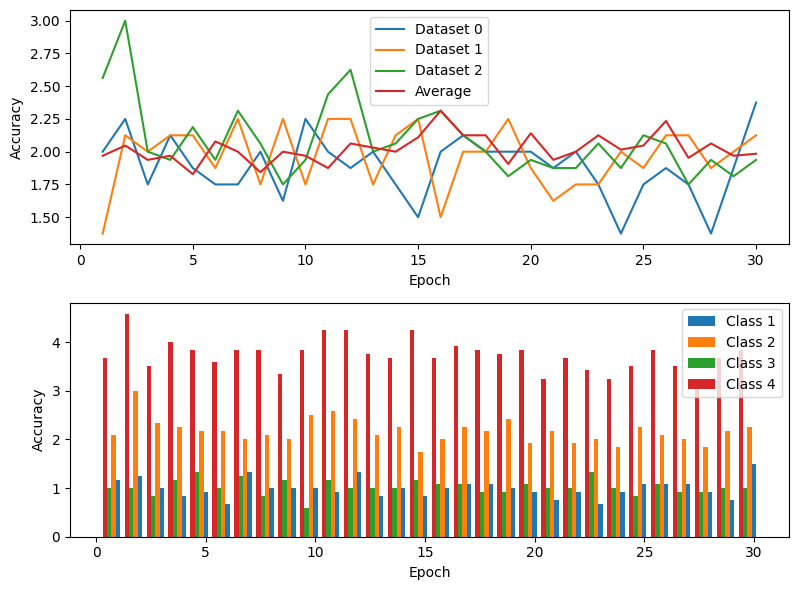

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting data for plotting
epoch_numbers = list(range(1, n_epochs + 1))

# 2) 3 overall accuracies (one for each dataset)
dataset_accuracies = [avg_test_accuracies] + test_accuracies

# 3) 4 accuracies (1 per class)
class_accuracies = [[np.mean([per_class_accuracies[j][epoch][i] for j in range(num_datasets)]) for i in range(output_size)] for epoch in range(n_epochs)]

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Line plot for accuracies per dataset
for i in range(num_datasets + 1):  # One line for the average accuracy
    if i == 3:
      label = 'Average'
      ax1.plot(epoch_numbers, train_accuracies, label=label)
    else:
      label = f'Dataset {i}'
      ax1.plot(epoch_numbers, test_accuracies[i], label=label)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Bar plot for accuracies per class
for i in range(output_size):
    ax2.bar(np.array(epoch_numbers) - 0.2 * i, [class_accuracies[epoch][i] for epoch in range(n_epochs)], width=0.2, label=f'Class {i + 1}')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout for better visualization
plt.tight_layout()
plt.show()